In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [12]:
import os

base_dir = './'
train_dir = os.path.join(base_dir, '../dataset/processed')
validation_dir = os.path.join(base_dir, '../dataset/test')

In [49]:
batch_size = 16
total_train = 164
total_test = 24
img_size = (img_width, img_height) = (300, 300)

In [50]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        horizontal_flip=True,
        shear_range = 0.2,
        fill_mode='nearest'
      )

test_datagen = ImageDataGenerator(rescale=1./255)

In [51]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 164 images belonging to 5 classes.
Found 24 images belonging to 5 classes.


In [52]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_width, img_height, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(5, activation='sigmoid')
    ])

    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  
    return model

In [53]:
checkpoint_path = './trained_model/model.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

In [54]:
model = create_model()

model.save_weights(checkpoint_path.format(epoch=0))

model.fit(
      train_generator,
      epochs=20,
      steps_per_epoch=total_train//batch_size,
      validation_data=validation_generator,
      validation_steps=total_test//batch_size, 
      callbacks=[cp_callback]
      )

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 2.2075 - accuracy: 0.3649
Epoch 1: saving model to ./trained_model\model.ckpt
10/10 [==============================] - 22s 2s/step - loss: 2.2075 - accuracy: 0.3649 - val_loss: 1.4889 - val_accuracy: 0.3750
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 1.0893 - accuracy: 0.5946
Epoch 2: saving model to ./trained_model\model.ckpt
10/10 [==============================] - 22s 2s/step - loss: 1.0893 - accuracy: 0.5946 - val_loss: 1.1968 - val_accuracy: 0.5625
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.8701 - accuracy: 0.6486
Epoch 3: saving model to ./trained_model\model.ckpt
10/10 [==============================] - 18s 2s/step - loss: 0.8701 - accuracy: 0.6486 - val_loss: 0.9554 - val_accuracy: 0.5625
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.5793 - accuracy: 0.7770
Epoch 4: saving model to ./trained_model\model.ckpt
10/10 [======================

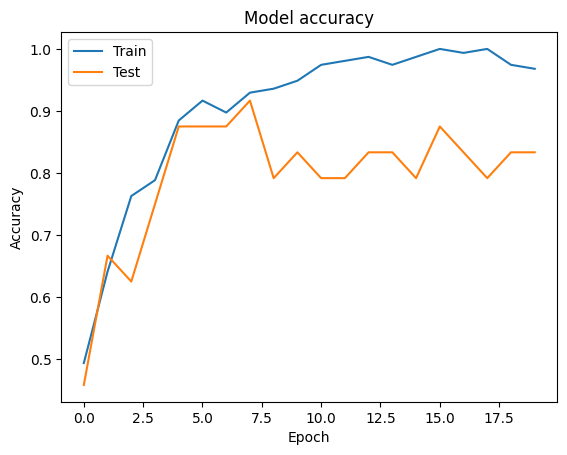

In [19]:
import matplotlib.pyplot as plt

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

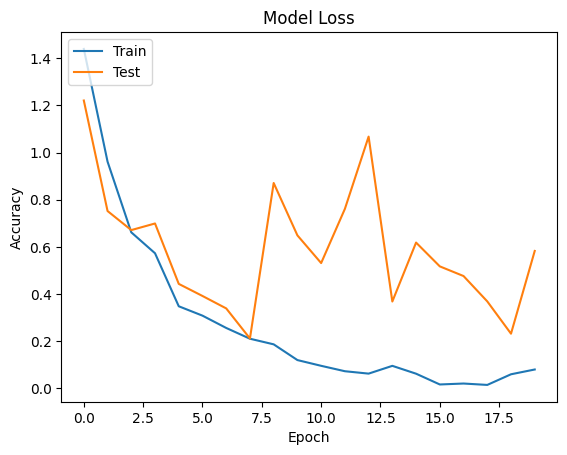

In [20]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
model.save_weights('./trained_model/weights.h5')
model.save('./trained_model/model.h5')

<h2>Load Model</h2>

In [2]:
reconstructed_model = tf.keras.models.load_model('./trained_model/model.h5')

<h2>Predicting an Image</h2>

In [39]:
def plot_value_array(predictions_array, true_label):
    plt.grid(False)
    plt.xticks(range(len(predictions_array)))
    plt.yticks([])
    thisplot = plt.bar(range(len(predictions_array)), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

1/1 [==============================] - 0s 121ms/step
[0. 0. 1. 1. 0.]


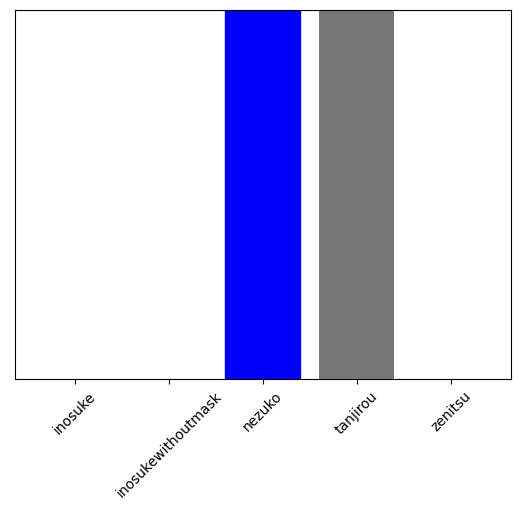

In [56]:
from keras.utils import load_img, img_to_array

# img = load_img('../dataset/processed/inosuke/1.jpg', target_size=img_size)
img = load_img('../dataset/input_sample/1.jpg', target_size=img_size)
img = img_to_array(img)
img = np.expand_dims(img, axis=0)

class_list = os.listdir(train_dir)
classes_count = len(class_list)
prediction = model.predict(img)
print(prediction[0])
# # print(prediction)
# # for id, pred in enumerate(prediction[0]):
# #     if pred == 1:
# #         print(class_list[id])

plot_value_array(prediction[0], 2)
_ = plt.xticks(range(classes_count), class_list, rotation=45)
plt.show()